<a href="https://colab.research.google.com/github/agustinLapi/MachineLearning/blob/main/Wines_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####El objetivo de este proyecto es hacer una regresión de los precios del vino de atributos como el país, la región y los puntos en wineenthusiast. Se le proporcionan casi 300K reseñas extraídas de WineEnthusiast durante junio y Noviembre de 2017. Piense en algunas preguntas interesantes que podría responder con estos datos: ¿qué vinos reciben una valoración más positiva? ¿Esta positividad se correlaciona con su precio? Más información sobre este conjunto de datos aquí.

In [37]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


wine_revs_1 = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectWNF/data/winemag-data_first150k.csv")
#wine_revs_1.head()

In [38]:
wine_revs_2 = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectWNF/data/winemag-data-second130k.csv")
#wine_revs_2.head()

In [39]:
wine_revs =pd.concat([wine_revs_1, wine_revs_2], ignore_index=True)
wine_revs.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,taster_name,taster_twitter_handle,title
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,NaN,NaN,NaN
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,NaN,NaN,NaN
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,NaN,NaN,NaN
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,NaN,NaN,NaN
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,NaN,NaN,NaN


In [40]:
wine_revs.columns

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'variety', 'winery',
       'taster_name', 'taster_twitter_handle', 'title'],
      dtype='object')

In [41]:
columns = ['description', 'points', 'price']
wine_revs = wine_revs[columns]

In [42]:
print('Information about the columns; type,entries,missing value info:  \n')
print(wine_revs.info())

Information about the columns; type,entries,missing value info:  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280901 entries, 0 to 280900
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   description  280901 non-null  object 
 1   points       280901 non-null  int64  
 2   price        258210 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB
None


In [43]:
print("Missing values in Dataset: /n", wine_revs.isnull().sum())

Missing values in Dataset: /n description        0
points             0
price          22691
dtype: int64


###Hago drop NA y duplicates solo en las columnas de description and points


In [44]:
#wine_revs = wine_revs.dropna( axis=0)
#print("After removing the missing entries in dataset: /n", wine_revs.info())
reviews = wine_revs[wine_revs.duplicated('description', keep=False)]
print("Length of dataframe after duplicates are removed:", len(reviews))

reviews =reviews.dropna(subset=['description', 'points', 'price'])
print("Length of dataframe after NaNs are removed:", len(reviews))
reviews.reset_index(inplace=True)

reviews.head()


Length of dataframe after duplicates are removed: 189527
Length of dataframe after NaNs are removed: 173045


,index,description,points,price
0,25,"Yields were down in 2015, but intensity is up,...",94,57.0
1,26,Bergström has made a Shea designate since 2003...,94,62.0
2,27,"Focused and dense, this intense wine captures ...",94,105.0
3,28,"Cranberry, baked rhubarb, anise and crushed sl...",94,60.0
4,29,This standout Rocks District wine brings earth...,94,60.0


In [45]:
np.any(np.isnan(reviews['price']))

False

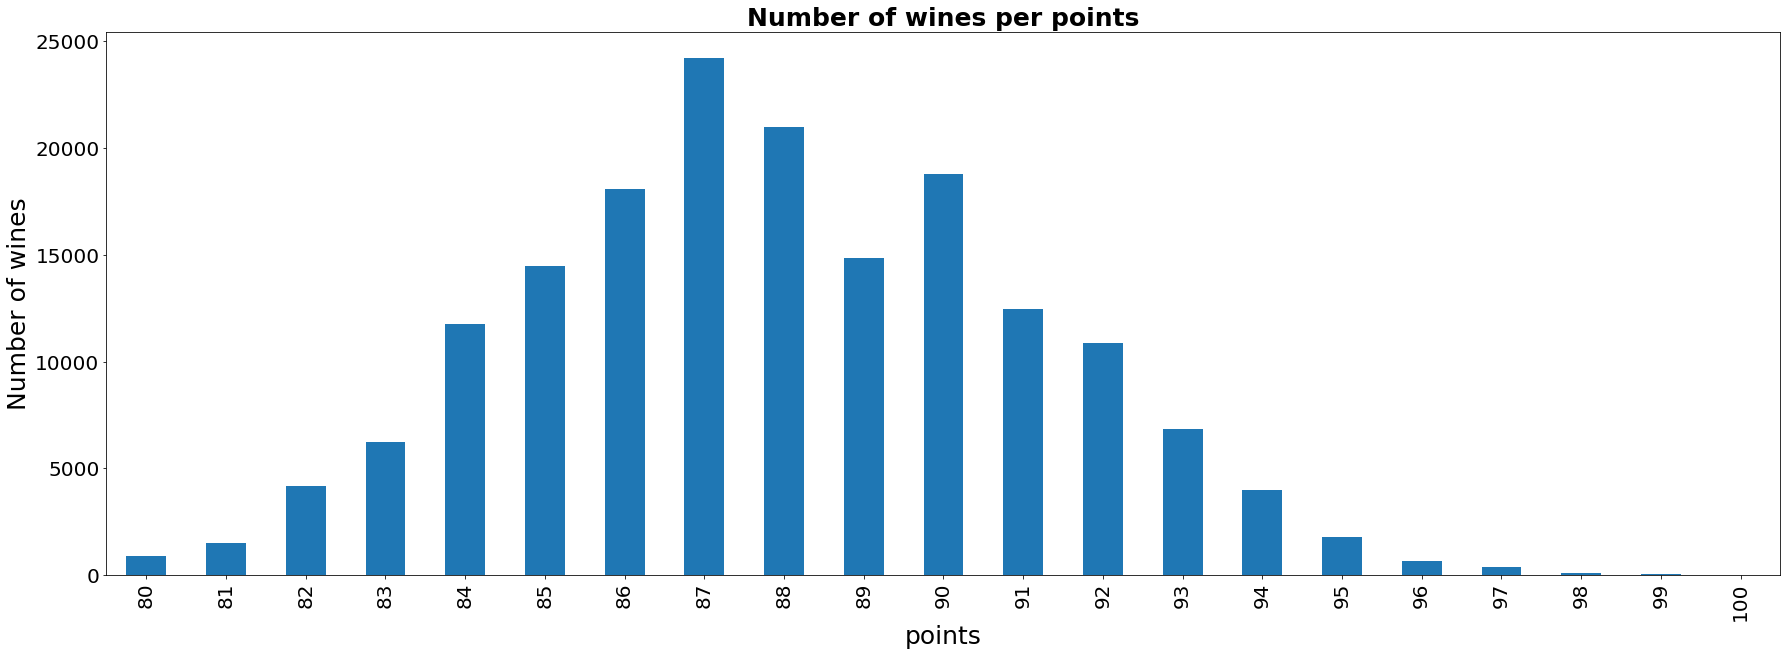

In [46]:
fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Number of wines per points', fontweight="bold", size=25) # Title
ax.set_ylabel('Number of wines', fontsize = 25) # Y label
ax.set_xlabel('Points', fontsize = 25) # X label
reviews.groupby(['points']).count()['description'].plot(ax=ax, kind='bar')

In [47]:
wine_revs.describe().T

,count,mean,std,min,25%,50%,75%,max
points,280901.0,88.146934,3.151528,80.0,86.0,88.0,90.0,100.0
price,258210.0,34.177162,38.611708,4.0,16.0,25.0,40.0,3300.0


In [48]:
reviews = reviews.assign(description_length = reviews['description'].apply(len))

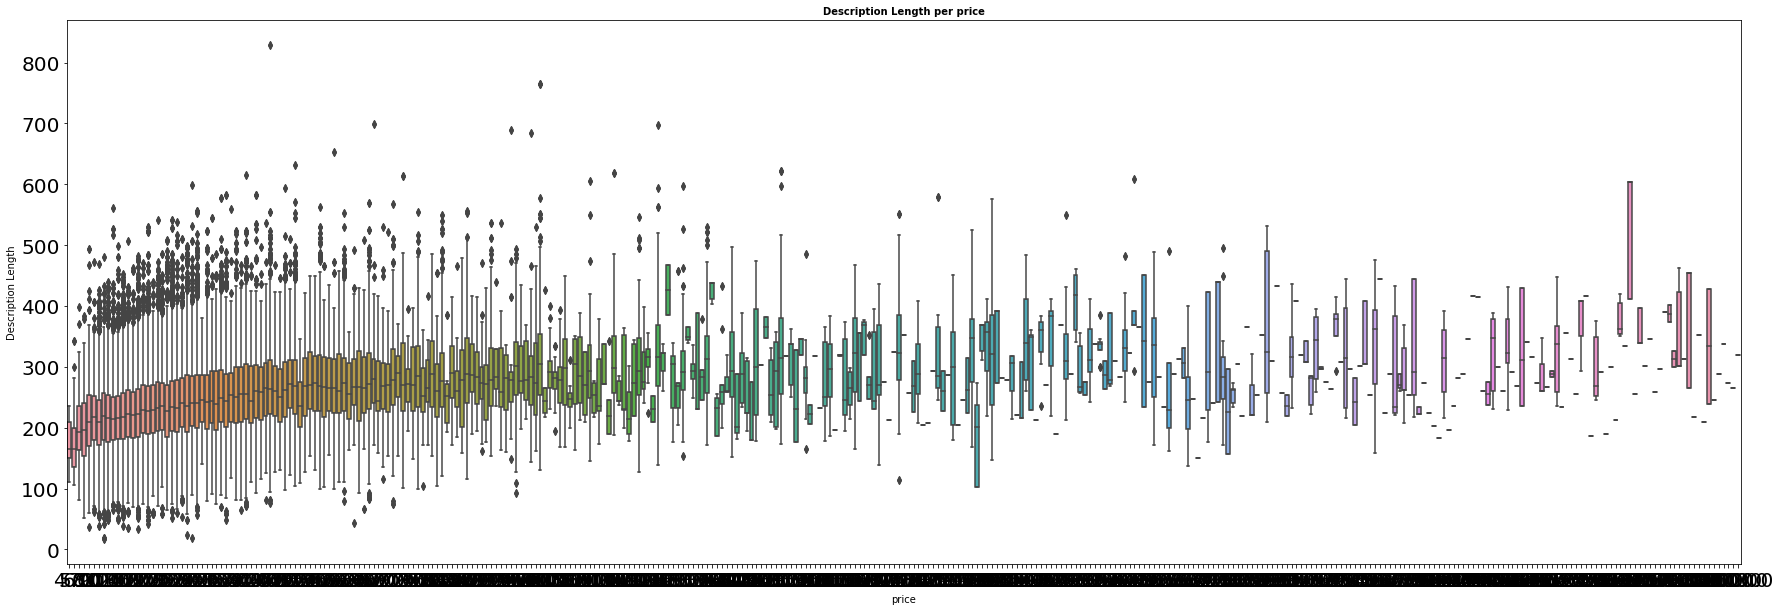

In [49]:

fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(x='price', y='description_length', data=reviews)
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Description Length per price', fontweight="bold", size=10) # Title
ax.set_ylabel('Description Length', fontsize = 10) # Y label
ax.set_xlabel('price', fontsize = 10) # X label
plt.show()

In [50]:
reviews.head()

,index,description,points,price,description_length
0,25,"Yields were down in 2015, but intensity is up,...",94,57.0,215
1,26,Bergström has made a Shea designate since 2003...,94,62.0,295
2,27,"Focused and dense, this intense wine captures ...",94,105.0,327
3,28,"Cranberry, baked rhubarb, anise and crushed sl...",94,60.0,292
4,29,This standout Rocks District wine brings earth...,94,60.0,333


In [51]:
np.max(reviews['price'])

2500.0

In [52]:
np.min(reviews['price'])

4.0

In [53]:
def transform_points_simplified(points):
    #distance = np.max(reviews.iloc[:]["points"])-np.min(reviews.iloc[:]["points"])

    if points >= 80 and points <= 82:
        return 4
    elif points >= 83 and points <= 85:
        return 5 
    elif points >= 86 and points <= 88:
        return 6 
    elif points >= 89 and points <= 91:
        return 7 
    elif points >= 92 and points <= 94:
        return 8
    elif points >= 95 and points <= 97:
        return 9
    else:
        return 10

#Applying transform method and assigning result to new column "points_simplified"
reviews = reviews.assign(points_simplified = reviews['points'].apply(transform_points_simplified))
reviews.head()

,index,description,points,price,description_length,points_simplified
0,25,"Yields were down in 2015, but intensity is up,...",94,57.0,215,8
1,26,Bergström has made a Shea designate since 2003...,94,62.0,295,8
2,27,"Focused and dense, this intense wine captures ...",94,105.0,327,8
3,28,"Cranberry, baked rhubarb, anise and crushed sl...",94,60.0,292,8
4,29,This standout Rocks District wine brings earth...,94,60.0,333,8


In [54]:
def price_normalization(price):
    #distance = np.max(reviews.iloc[:]["points"])-np.min(reviews.iloc[:]["points"])
    
    return (price /(2500-4))*100

#Applying transform method and assigning result to new column "points_simplified"
reviews = reviews.assign(price_normalization = reviews['price'].apply(price_normalization))
reviews.head()

,index,description,points,price,description_length,points_simplified,price_normalization
0,25,"Yields were down in 2015, but intensity is up,...",94,57.0,215,8,2.283654
1,26,Bergström has made a Shea designate since 2003...,94,62.0,295,8,2.483974
2,27,"Focused and dense, this intense wine captures ...",94,105.0,327,8,4.206731
3,28,"Cranberry, baked rhubarb, anise and crushed sl...",94,60.0,292,8,2.403846
4,29,This standout Rocks District wine brings earth...,94,60.0,333,8,2.403846


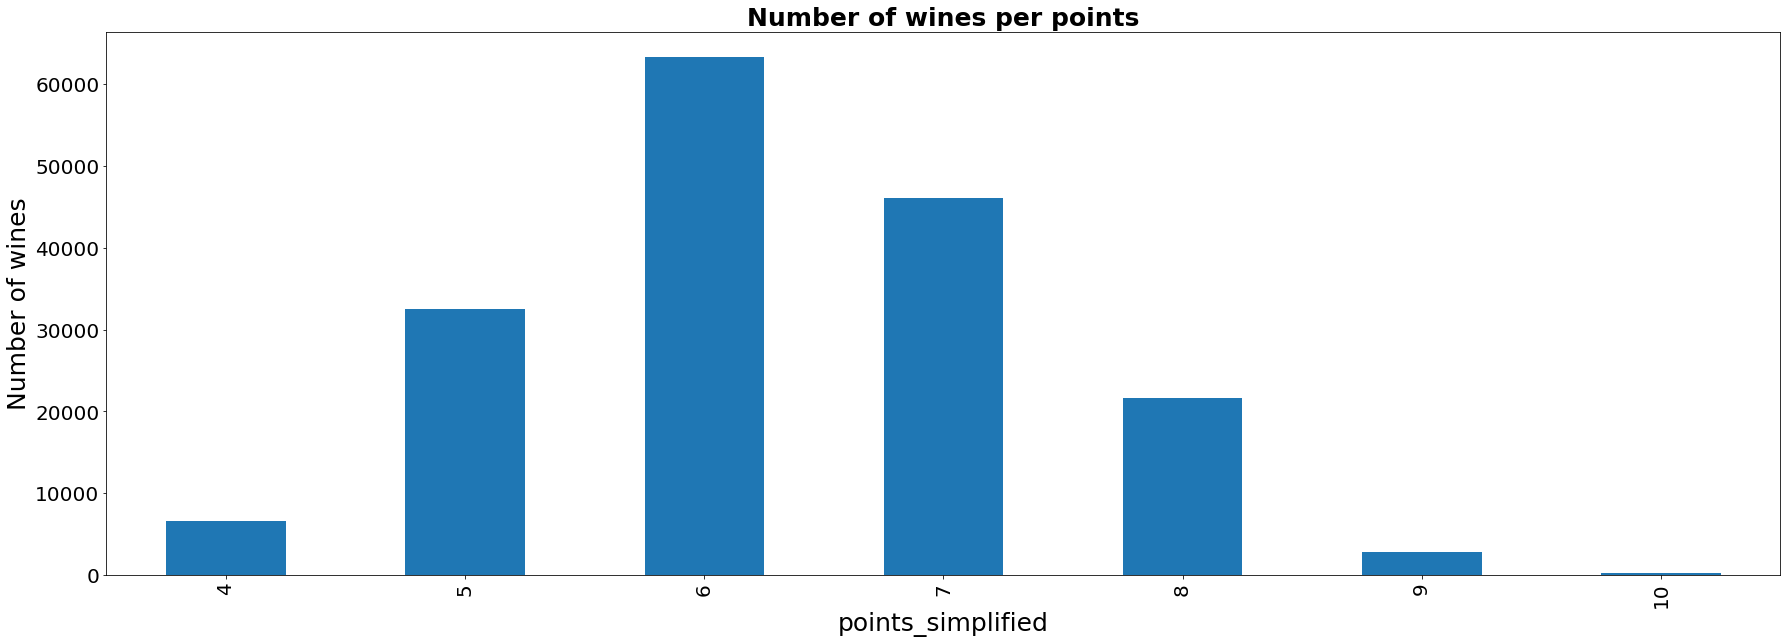

In [55]:
fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Number of wines per points', fontweight="bold", size=25) # Title
ax.set_ylabel('Number of wines', fontsize = 25) # Y label
ax.set_xlabel('Points', fontsize = 25) # X label
reviews.groupby(['points_simplified']).count()['description'].plot(ax=ax, kind='bar')

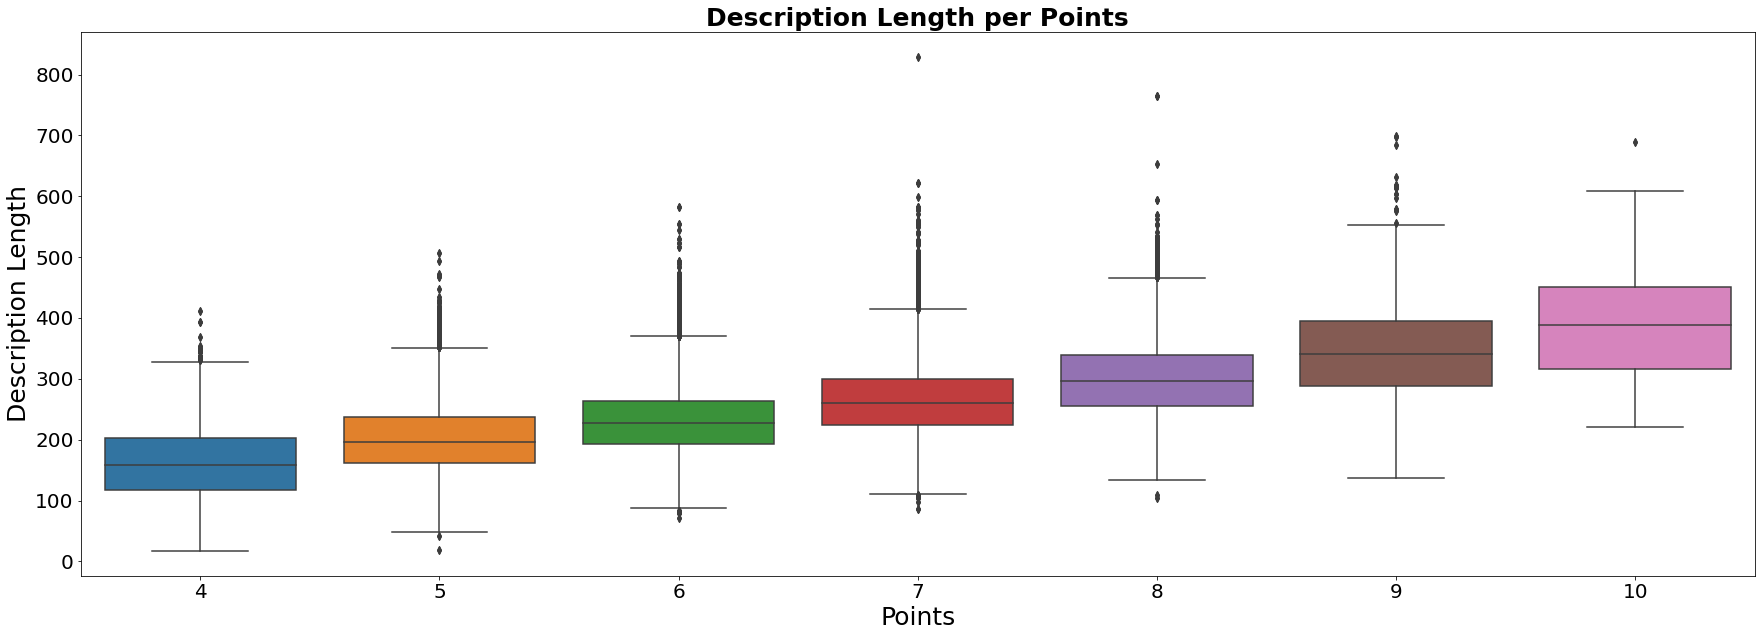

In [56]:
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(x='points_simplified', y='description_length', data=reviews)
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Description Length per Points', fontweight="bold", size=25) # Title
ax.set_ylabel('Description Length', fontsize = 25) # Y label
ax.set_xlabel('Points', fontsize = 25) # X label
plt.show()

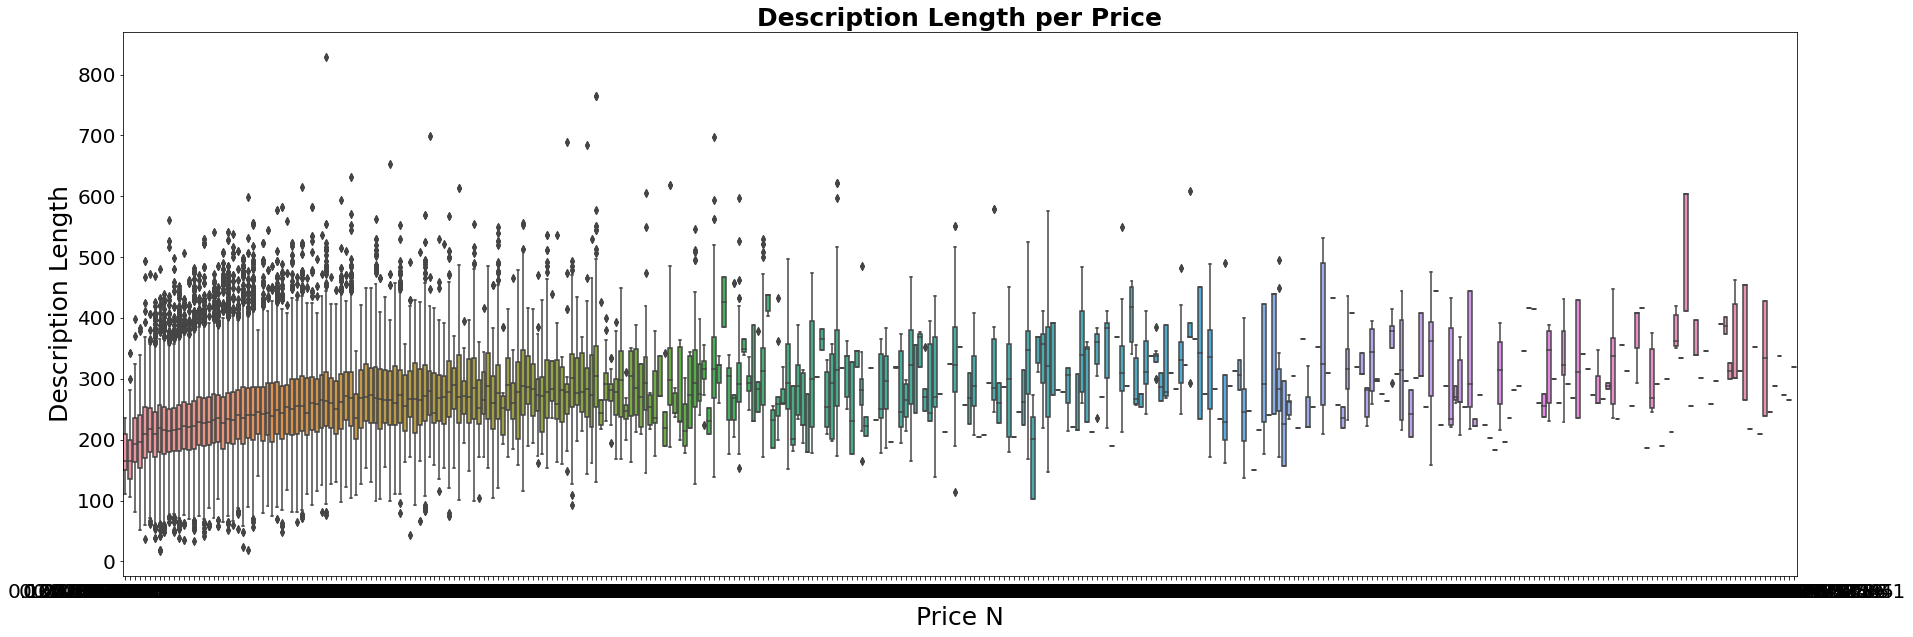

In [57]:
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(x='price_normalization', y='description_length', data=reviews)
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Description Length per Price', fontweight="bold", size=25) # Title
ax.set_ylabel('Description Length', fontsize = 25) # Y label
ax.set_xlabel('Price N', fontsize = 25) # X label
plt.show()

In [58]:
#columns = ['description', 'points_simplified']
X = reviews['description']
y = reviews['price_normalization']

vectorizer = CountVectorizer()
vectorizer.fit(X)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [59]:
X = vectorizer.transform(X)
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (173045, 26693)
Amount of Non-Zero occurrences:  5958013
Density: 0.1289867216567455


In [24]:
#np.any(np.isnan(reviews['points_simplified']))
#reviews.shape
#reviews.reset_index(inplace=True)

In [25]:
#H = pd.DataFrame.sparse.from_spmatrix(X)
#H['points_simplified'] = reviews['points_simplified']
#H.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,26654,26655,26656,26657,26658,26659,26660,26661,26662,26663,26664,26665,26666,26667,26668,26669,26670,26671,26672,26673,26674,26675,26676,26677,26678,26679,26680,26681,26682,26683,26684,26685,26686,26687,26688,26689,26690,26691,26692,points_simplified
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8


In [60]:
#X = H 
# Training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

#rfc = RandomForestClassifier()
#rfc.fit(X_train, y_train)
# Testing the model
#predictions = rfc.predict(X_test)
#print(classification_report(y_test, predictions))

In [27]:
#X = reviews['description']
#y = reviews['price']

# Vectorizing model
#vectorizer = TfidfVectorizer()
#vectorizer.fit(X)
#X = vectorizer.transform(X)

# Training model
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
#rfc = RandomForestClassifier()
#rfc.fit(X_train, y_train)

# Testing model
#predictions = rfc.predict(X_test)
#print(classification_report(y_test, predictions))

In [61]:
from sklearn.linear_model import LinearRegression
# Instancia de la regresión lineal
linear_regressor = LinearRegression()

# Ajuste el modelo a los datos de entrenamiento (aprenda los coeficientes)
fit = linear_regressor.fit(X_train, y_train)


In [62]:
fit.score(X_train, y_train)

0.59970445748303

In [63]:
# Print coefficients and intercept
print(fit.intercept_)
print(fit.coef_)

0.6559645750111317
[-0.46728556 -0.18277247 -0.11492058 ... -0.17773167 -0.33769601
 -0.14703202]


In [64]:
# Predict X_test
y_pred = fit.predict(X_test)
y_pred

array([2.63362386, 1.64278492, 0.96148687, ..., 2.39311909, 0.85359419,
       0.78280963])

In [65]:
# calculamos MAE usando scikit-learn
from sklearn import metrics
print("MAE =", metrics.mean_absolute_error(y_test, y_pred))

MAE = 0.5296690722731778


In [66]:
print("MSE =",metrics.mean_squared_error(y_test, y_pred))

MSE = 0.9680213228264966


In [67]:
print("RMSE =",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE = 0.9838807462423973


In [68]:
# Calcular rmse por cada muestra
test_pred_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'RMSE':np.sqrt((y_test-y_pred)**2)})
test_pred_df.head()

,y_test,y_pred,RMSE
2544,2.524038,2.633624,0.109585
107090,1.001603,1.642785,0.641182
63644,0.961538,0.961487,0.000052
143564,0.801282,1.342848,0.541566
83010,2.604167,2.604094,0.000073


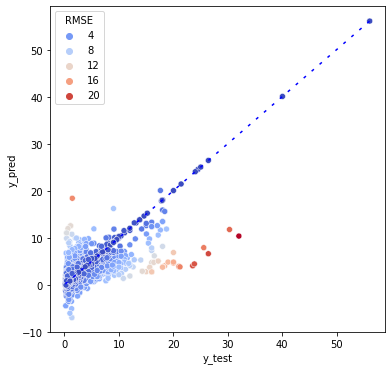

In [69]:
plt.figure(figsize=(6,6))

# Scatter plot (Gráfico de dispersión) y_test vs. y_pred
sns.scatterplot(x='y_test', y='y_pred', hue='RMSE', palette='coolwarm', data = test_pred_df)

# y_test = y_pred line. Cuanto más cerca estén los puntos de esta línea, mejor será la predicción.
X_plot = np.linspace(test_pred_df['y_test'].min(), test_pred_df['y_test'].max(), 100)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, color='b', dashes=[2, 5, 2, 5])

In [70]:
test_pred_df = pd.DataFrame({'y_test': (y_test*2496 +4), 'y_pred': (y_pred*2496 +4), 'RMSE':np.sqrt(((y_test-y_pred)*2496 +4)**2)})
test_pred_df.head()

,y_test,y_pred,RMSE
2544,6304.0,6577.525151,269.525151
107090,2504.0,4104.391150,1596.391150
63644,2404.0,2403.871233,4.128767
143564,2004.0,3355.747816,1347.747816
83010,6504.0,6503.818789,4.181211


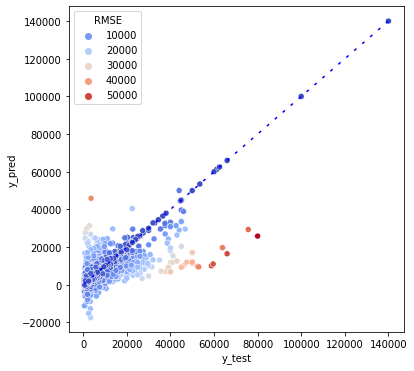

In [71]:
plt.figure(figsize=(6,6))

# Scatter plot (Gráfico de dispersión) y_test vs. y_pred
sns.scatterplot(x='y_test', y='y_pred', hue='RMSE', palette='coolwarm', data = test_pred_df)

# y_test = y_pred line. Cuanto más cerca estén los puntos de esta línea, mejor será la predicción.
X_plot = np.linspace(test_pred_df['y_test'].min(), test_pred_df['y_test'].max(), 100)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, color='b', dashes=[2, 5, 2, 5])

In [72]:
print(np.mean(test_pred_df['RMSE']))

1322.3027652577614


###Se puede concluir que es posible realizar una correlación entre las reseñas y los puntajes que se le dan a los vinos. Se realizó una normalización previa de los puntajes y de los precios de los vinos para que sea más fácil tratar los datos. 
###A partir de las reseñas se intentó predecir el precio de los vinos, esto en principio funcionó muy bien para un grupo de los vinos pero no tanto para otros. Creo que uno de los grandes inconvenientes del regresor es que toma dos valores muy alejados (outliers) como parte de la regresión. Éstos dos valores se corresponden a dos vinos en particular cuyo precio es muy por encima del resto. Estaría bueno realizar un nuevo análisis eliminando estos dos outliers.
###Por otro lado se intentó apicar una regresión logística pero no se llegó a ningún resultado dado que se superan la cantidad máxima de iteraciones
###En último lugar estaría bueno tener en cuenta mayor cantidad de columnas para realizar la regresión para ver cómo se modifican estos resultados. 


In [97]:
X = reviews['description']
y = reviews['price']

vectorizer = CountVectorizer()
vectorizer.fit(X)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [98]:
X = vectorizer.transform(X)
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (173045, 26693)
Amount of Non-Zero occurrences:  5958013
Density: 0.1289867216567455


In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [100]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(solver='lbfgs', multi_class='ovr').fit(X_train, y_train)
LR.predict(X.test)



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


AttributeError: ignored

In [75]:
round(LR.score(X,y), 4)

[ 0. -0. -0. ... -0.  0. -0.]


In [79]:
print("MAE =", metrics.mean_absolute_error(y_test, y_pred))

MAE = 0.7490318184048979


In [80]:
print("MSE =",metrics.mean_squared_error(y_test, y_pred))

MSE = 1.8720750975768035


In [81]:
print("RMSE =",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE = 1.368237953565389


In [82]:
# Calcular rmse por cada muestra
test_pred_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'RMSE':np.sqrt((y_test-y_pred)**2)})
test_pred_df.head()

,y_test,y_pred,RMSE
2544,2.524038,1.378826,1.145212
107090,1.001603,1.424414,0.422811
63644,0.961538,1.432460,0.470922
143564,0.801282,1.348819,0.547537
83010,2.604167,1.462468,1.141699
